In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[]


2022-06-22 12:59:57.766159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-06-22 12:59:57.766189: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
N = 10**5

#Synthetic
theta0_G = np.random.normal(0.2,0.8,N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

#Natural
theta_unknown_G = np.random.normal(0,1, N)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G]) 

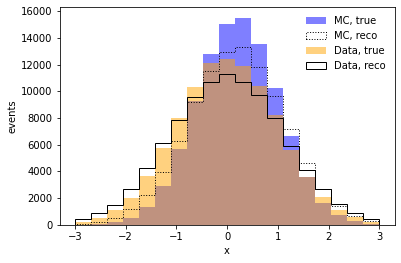

In [4]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

In [5]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2022-06-22 13:00:01.453620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
myweights = of.omnifold(theta0,theta_unknown_S,2,model)

ValueError: in user code:

    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/keras/backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((10000, 1) vs (10000, 2)).


NameError: name 'myweights' is not defined

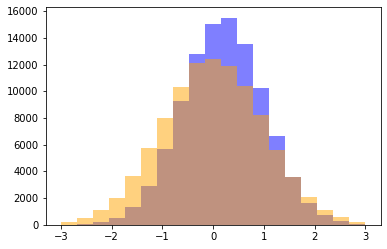

In [7]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G,weights=myweights[-1, 0, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw="2")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)